# Week of 2025.04.14

- [ ]  Atmosphere integration
    - [ ]  Couple new conduit flow with slip to atmosphere
    - [ ]  Look into Fred’s thesis on 1D/2D pairing with atmosphere
    - [ ]  Possibly add simple approximation of atmosphere to lumped parameter
    - [ ]  Look into using linear acoustics to extent lumped parameter model to include outputs for the atmosphere.
- [ ]  Lumped parameter search
    - [ ]  Get inversion code that Mario is working on up and running
    - [ ]  Make lumped parameter model match ‘eruption’ that Mario is experimenting with
- [ ] Support Mario with slip feature

## 1.0 Review the simulation that Mario developed where the volcano is erupting

Relevant parameters:

$$\tau_{peak} =1e4 \\
\tau_r = 0 \\
D_c = 2 \\
R = 5
$$

In [6]:
from helper_code.slip_imports import *

ani = animate.animate_conduit_pressure("eruption_model", iterations=250, file_prefix="tungurahua_rad_5_v19_conduit", viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=7, max_viscosity=10, max_speed_of_sound=250)

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## 2.0 Eruption emulated with lumped parameter model 

Let's start with the [Lumped Parameter model](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.03.26.experiments.html) I was using a couple of weeks ago. 

### 2.1 Review Differential Equations

Let's review the forces at play: 

**Pressure balance:**

$$
\begin{equation}
M \ddot{s} = A p_0 + \Delta p(s) A - p_{atm} A \\
\end{equation}
$$

The $\Delta p (s)$ term is different depending on if we assume a very fast interaction where the conduit is best modeled as an infinite pipe, or if we assume a slower moving interaction where enough time passes to ignore the wave effects:

In the radiation damping fast limit:
$$
\Delta p = - \rho c \dot{s}
$$

In the slow limit 
$$
\Delta p = \frac{-K s}{L_{melt} + s}
$$

**Wall friction:**
$$
\begin{equation}
M \ddot{s} = - 2 \pi R \tau(s) (L_{plug} - s)
\end{equation}
$$

At the moment, we are using a liner model for wall friction, so $\tau$ is defined as a piecewise function of slip.

**Viscous friction:**
$$
\begin{equation}
M \ddot{s} = - 4 \pi \mu (L_{melt} + s) \dot{s}
\end{equation}
$$

**Gravity:**

$$
\begin{equation}
M \ddot{s} = -g
\end{equation}
$$

**Overall DE:**

$$
\begin{equation}
M \ddot{s} = A (p_0 - \rho c \dot{s} - p_{atm}) - 2 \pi R \tau(s)(L_{plug} - s) - 4 \pi \mu (L_{melt} + s) \dot{s} - g
\end{equation}
$$

In [7]:
from scipy.integrate import odeint

# Define constants (you can modify these values as needed)
K = 1e10      # Some constant (friction/damping)
L_melt = 950 # Melt length
tau_peak = 1e4  # principle shear stress
tau_r = 0  # residual shear stress
R = 5      # Radius [m]
L_plug = 50 # Plug length
g = 9.81  # Acceleration due to gravity [m/s^2]

rho = 2.6e3  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 130 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug * (1 + L_melt / (L_plug*2))
D_c = 2

# viscosity
mu = 5e6

A = np.pi * R**2  # Cross-sectional area
p0 = 3e6  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure


NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER = 1.0

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_peak - (tau_peak - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    # ds2/dt = (-A*K*s2)/(M*L_melt) + ((tau_p - tau_s)*2*pi*R*(L_plug - s1)*s1)/M
    ds2_dt =  (-rho * C * s2) / (M_plug)  \
            + (A * (p0 - p_atm) / M_plug) \
            - (tau(s1) * 2 * np.pi * R * (L_plug - s1)) / M_plug  \
            - g/M_plug
            #- 4 * np.pi * mu * (L_melt+s1) * s2 / M_plug \
    
    return [ds1_dt, ds2_dt]

# Time points
t = np.linspace(0, 3, 1000)  # Time from 0 to 10 with 1000 points

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Solve the differential equations
solution = odeint(system, initial_state, t)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

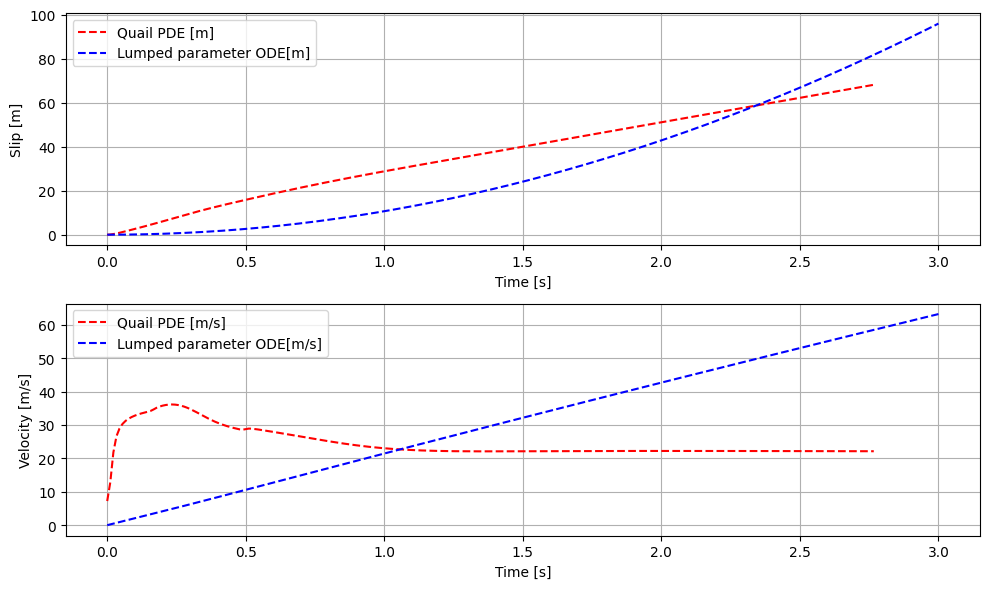

In [8]:
folder = "eruption_model"
file_prefix = "tungurahua_rad_5_v19_conduit"
N = 250
slip_time_series = []
times = []

for i in range(0, N):
    solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{i}.pkl")
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")]/rho_mix).ravel()[-1])
    times.append(solver.time)

ds_dt_quail = np.gradient(slip_time_series, times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'r--', label='Quail PDE [m]')
plt.plot(t, s1, 'b--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("Slip [m]")
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(times, ds_dt_quail, 'r--', label='Quail PDE [m/s]')
plt.plot(t, s2, 'b--', label='Lumped parameter ODE[m/s]')
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

## 2.2 What is missing from the lumped parameter model? 

Thinks to experiment with:
1. If we change the inlet boundary condition to just be the closed end of a pipe does that reduce the explosiveness? 
2. 



# 3.0 Adding atmosphere to the eruption model

In [9]:
from helper_code.slip_imports import *

ani = animate.animate_conduit_pressure("eruption_model", iterations=50, file_prefix="tungurahua_rad_5_v20_conduit", viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=7, max_viscosity=10, max_speed_of_sound=250)

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


In [52]:
# Function to read the i-th file for the 2D part
solver2D_from = lambda i: readwritedatafiles.read_data_file(
  f"eruption_model/tungurahua_rad_5_v20_conduit_{i}.pkl")

# Extract solver
solver2D = solver2D_from(0)

print("The shape of state_coeffs for 2D is:")
print(solver2D.state_coeffs.shape)

The shape of state_coeffs for 2D is:
(400, 1, 9)


In [53]:
x_nodes = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs, :]
x_nodes.shape

(400, 2, 1)

# 4.0 Updating the lumped parameter model with atmospheric affects

# Support Mario with slip feature

## First, Mario is having challenges with the `compute_plug_boundary` call. 

Let's see if we can duplicate his challenges locally. 

In [ ]:
from helper_code.slip_imports import *

folder = "mario_file_review/test_plug_boundary"
file_prefix = "tungurahua_rad_5_v15_conduit_"
solver = lambda i : readwritedatafiles.read_data_file(f"{folder}/{file_prefix}{i}.pkl")

ani = animate.animate_conduit_pressure(solver, iterations=50, viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=7, max_speed_of_sound=250)

HTML(ani.to_html5_video())

TypeError: animate_conduit_pressure() got an unexpected keyword argument 'max_viscosity'. Did you mean 'max_velocity'?